<a href="https://colab.research.google.com/github/LoKe220723/Reinforcement-Learning/blob/main/RLrobot_2(Lokesh21csu405).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [30]:
class PowerSocket:
    """ the base power socket class """

    def __init__(self, q):
        self.q = q        # the true reward value
        self.initialize() # reset the socket

    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value
        self.n = 0   # the number of times this socket has been tried

    def charge(self):
        """ return a random amount of charge """

        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q

        # never allow a charge less than 0 to be returned
        return 0 if value < 0 else value

    def update(self,R):
        """ update this socket after it has returned reward value 'R' """

        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def sample(self):
        """ return an estimate of the socket's reward value """
        return self.Q


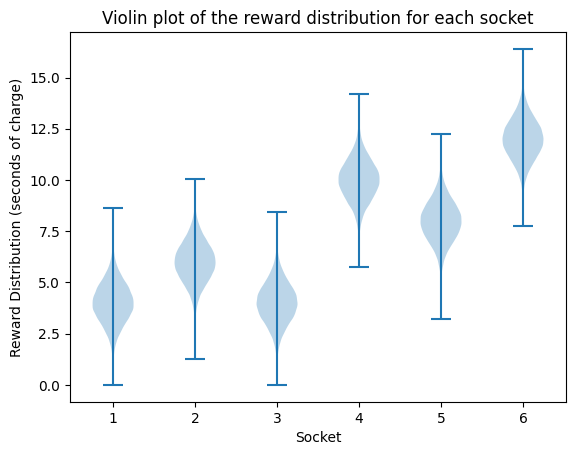

In [31]:
# create 5 sockets in a fixed order
socket_order = [1,2,1,4,3,5]

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [PowerSocket((q*2)+2) for q in socket_order]

# save the number of sockets
NUM_SOCKETS = len(socket_order)
# using a very large number of time steps just to create sufficient data to get smooth plots of socket output
TOTAL_STEPS = 100000

# rewards will contain the charge returned at all of the time steps for each socket
rewards = np.zeros(shape=(TOTAL_STEPS,NUM_SOCKETS))

# iterate through each of the sockets
for socket_number,socket in enumerate(sockets):

    # get charge from the socket for the defined number of steps
    for t in range(TOTAL_STEPS): rewards[t,socket_number] = socket.charge()

# plot the charge we got from the sockets
plt.violinplot(rewards)
plt.xlabel('Socket')
plt.ylabel('Reward Distribution (seconds of charge)')
plt.title('Violin plot of the reward distribution for each socket')
plt.show()


In [32]:
class SocketTester():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket=PowerSocket, socket_order=socket_order, multiplier=2, **kwargs ):

        # create supplied socket type with a mean value defined by socket order
        self.sockets = [socket((q*multiplier)+2, **kwargs) for q in socket_order]

    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """

        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

    def select_socket( self, t ):
        """ choose the socket with the current highest mean reward or arbitrarily
            select a socket in the case of a tie """
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])
        return socket_index


    def run( self, number_of_steps, maximum_total_reward = float('inf')):
        """ perform a single run for the defined number of steps """

        for t in range(number_of_steps):
            # select a socket
            socket_index = self.select_socket(t)

            # charge from the chosen socket and update its mean reward value
            self.charge_and_update(socket_index)


In [33]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *


In [34]:
class OptimisticSocket( PowerSocket ):
    def __init__( self, q, **kwargs ):

        # get the initial estimate from the kwargs
        self.initial_estimate = kwargs.pop('initial_estimate', 0.)

        # pass the true reward value to the base PowerSocket
        super().__init__(q)


    def initialize(self):
        # estimate of this socket's reward value
        # - set to supplied initial value
        self.Q = self.initial_estimate

        # the number of times this socket has been tried
        # - set to 1 if an initialisation value is supplied
        self.n = 1 if self.initial_estimate  > 0 else 0


In [35]:
def highlight_max_row_value( row ):
    '''
    highlight the maximum value on the supplied row
    '''
    is_max = row == row.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_change_in_column( col ):
    '''
    highlight the entry before the column value changes
    '''
    style = []
    for i in range(col.shape[0]):
        if i < (col.shape[0]-1) and col.iloc[i] != col.iloc[i+1]:
            style.append('background-color: yellow')
        else:
            style.append('')
    return style

# Test the optimistic socket over 30 time steps
tester = SocketTester( OptimisticSocket, initial_estimate = 20.)
tester.run( number_of_steps = 30 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage():0.3f}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')

# convert to a Pandas dataframe for table display & rename the columns to be 1-based
estimates = tester.socket_stats[:,:,0]
df = pd.DataFrame(estimates[:21])
df.columns = [1,2,3,4,5]

# show the estimates of each socket, highlighting the socket that has been selected for each time step
# - truncating to the first 20 time steps for clarity
df.style.apply(highlight_change_in_column).apply(highlight_max_row_value,axis=1,subset=df.index[-1])


Mean Reward per Time Step = 10.839500768143346
Optimal Socket Selected = 0.690
Socket Percentages = [0.103 0.103 0.138 0.690 0.138]


,1,2,3,4,5
0,20.000000,20.000000,20.000000,20.000000,20.000000
1,13.417260,20.000000,20.000000,20.000000,20.000000
2,13.417260,20.000000,20.000000,20.000000,14.803223
3,13.417260,12.522481,20.000000,20.000000,14.803223
4,13.417260,12.522481,20.000000,15.794269,14.803223
5,13.417260,12.522481,14.814345,15.794269,14.803223
6,13.417260,12.522481,14.814345,13.924483,14.803223
7,13.417260,12.522481,12.744737,13.924483,14.803223
8,13.417260,12.522481,12.744737,13.924483,13.100123
9,13.417260,12.522481,12.744737,13.541121,13.100123


Text(0, 0.5, 'Socket Reward Estimate')

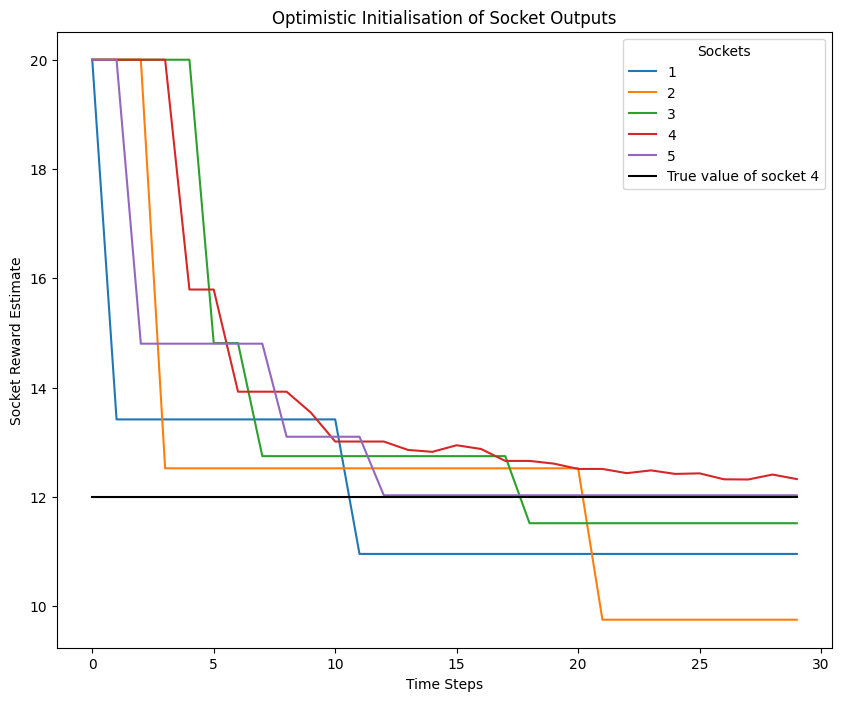

In [37]:
plt.figure(figsize=(10,8))

for socket in range(estimates.shape[1]):
    plt.plot(estimates[:30,socket], label = f'{socket+1}')

plt.plot(np.ones(30)*np.max(socket_means),'k', label = f'True value of socket 4')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation of Socket Outputs')
plt.xlabel('Time Steps')
plt.ylabel('Socket Reward Estimate')


100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


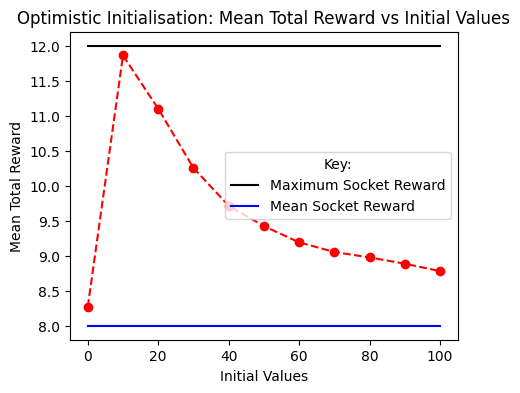

In [38]:
def plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(10,8) ):

    plt.figure(figsize=figsize)
    plt.plot( initial_values, reward, marker='o', linestyle='--', color='r')

    # draw reference lines
    plt.plot(np.ones(max_initial_value+1)*np.max(socket_means),'k', label = f'Maximum Socket Reward')
    plt.plot(np.ones(max_initial_value+1)*np.mean(socket_means),'b', label = f'Mean Socket Reward')

    plt.legend(title = 'Key:')
    plt.title('Optimistic Initialisation: Mean Total Reward vs Initial Values')
    plt.xlabel('Initial Values')
    plt.ylabel('Mean Total Reward')

def run_initialisation_experiment( start, end, step = 1 ):
    """ test varying the initial estimate for optimistic-greedy """

    number_of_tests = 1000
    number_of_steps = 30
    number_of_sockets = len(socket_order)

    reward = []
    optimal_selected = []
    socket_percentages = []
    initial_values = []

    # iterate over the initial estimate values
    for initial_estimate in tqdm(range( start, (end+step), step )):

        initial_values.append( initial_estimate )

        socket_tester = SocketTester( OptimisticSocket, socket_order, initial_estimate = initial_estimate)

        socket_experiment = SocketExperiment(socket_tester = socket_tester,
                                             number_of_tests = number_of_tests,
                                             number_of_steps = number_of_steps)
        socket_experiment.run()

        reward.append( socket_experiment.get_mean_total_reward() )
        optimal_selected.append( socket_experiment.get_optimal_selected() )
        socket_percentages.append( socket_experiment.get_socket_percentages() )

    return initial_values, reward, optimal_selected, socket_percentages

max_initial_value = 100
step = 10
initial_values, reward, optimal_selected, socket_percentages = run_initialisation_experiment( 0, max_initial_value, step )
plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(5,4) )



Text(0, 0.5, 'Socket Selection (%)')

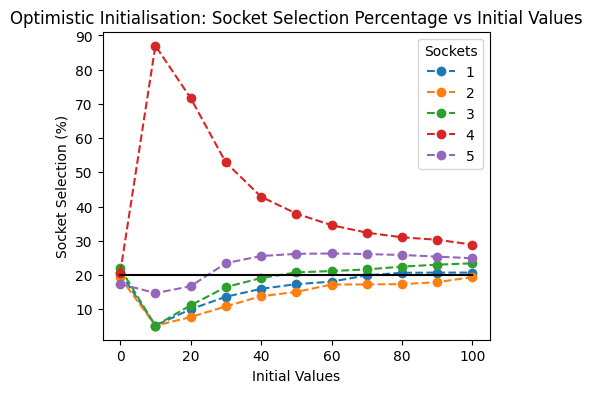

In [39]:
df = pd.DataFrame(socket_percentages)

plt.figure(figsize=(5,4))

for socket in range(df.shape[1]):
    plt.plot(initial_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')

plt.plot(initial_values, np.ones(df.shape[0])*20,'k')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation: Socket Selection Percentage vs Initial Values')
plt.xlabel('Initial Values')
plt.ylabel('Socket Selection (%)')


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


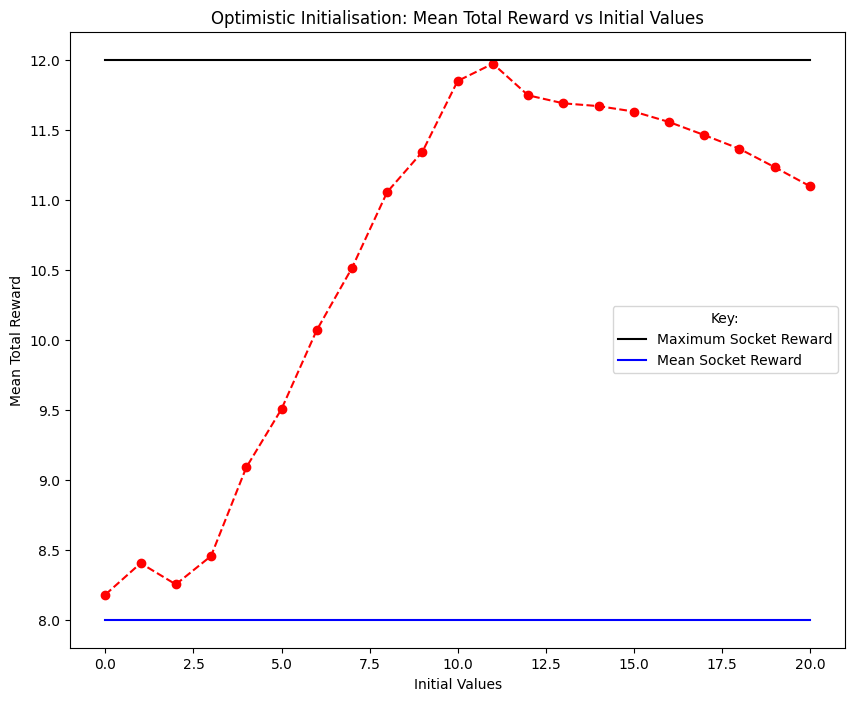

In [40]:
max_initial_value = 20
step = 1
initial_values, reward, optimal_selected, socket_percentages = run_initialisation_experiment( 0, max_initial_value, step )
plot_initial_optimisation( initial_values, reward, max_initial_value )
